In [1]:
# !pip install fastai==0.7.0

In [1]:
!pip show fastai

Name: fastai
Version: 0.7.0
Summary: The fastai deep learning and machine learning library.
Home-page: https://github.com/fastai/fastai
Author: Jeremy Howard and contributors
Author-email: info@fast.ai
License: Apache License 2.0
Location: /home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6/site-packages
Requires: pyzmq, pandas-summary, bleach, PyYAML, graphviz, Pygments, torch, cycler, pickleshare, isoweek, entrypoints, Pillow, ipywidgets, tornado, tqdm, jupyter, ipython, jsonschema, html5lib, ptyprocess, opencv-python, wcwidth, bcolz, simplegeneric, jedi, ipykernel, matplotlib, webencodings, decorator, Jinja2, MarkupSafe, seaborn, widgetsnbextension, numpy, certifi, scipy, feather-format, torchtext, testpath, pyparsing, sklearn-pandas, torchvision, python-dateutil, traitlets, plotnine, pandas, pytz, ipython-genutils
Required-by: 


In [1]:
from fastai.text import *
import html

In [2]:
torch.cuda.set_device(1)

In [3]:
torch.cuda.current_device()

1

In [4]:
import sys, os
print(sys.path)

['', '/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python36.zip', '/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6', '/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6/lib-dynload', '/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6/site-packages', '/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6/site-packages/IPython/extensions', '/home/nuthakkisiddhartha/.ipython']


In [5]:
%pwd

'/home/nuthakkisiddhartha/diagnosis_top50_80-20split'

In [6]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('/home/nuthakkisiddhartha/diagnosis_top50_80-20split')

In [7]:
CLAS_PATH=Path('/home/nuthakkisiddhartha/diagnosis_top50_80-20split/mimic_diag_seq1_top50_clas_80:20split/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('/home/nuthakkisiddhartha/diagnosis_top50_80-20split/diag_seq1_top50_lm_80-20split/')
LM_PATH.mkdir(exist_ok=True)

In [8]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')

In [9]:
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

In [10]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [11]:
vs=len(itos)
vs,len(trn_lm)

(60002, 847190)

# wikitext103 conversion

In [12]:
em_sz,nh,nl = 400,1150,3

In [13]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [14]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [15]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [16]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [17]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [18]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language model

In [20]:
wd=1e-7
bptt=30
bs=130
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [21]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [22]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [23]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

In [24]:
learner.metrics = [accuracy]

In [ ]:
learner.freeze_to(-1)

In [30]:
learner.model.load_state_dict(wgts)

In [25]:
lr=1e-3
lrs = lr

In [32]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                           
    0      2.932983   2.674406   0.505045  



[array([2.67441]), 0.5050445304016099]

In [33]:
learner.save('lm_last_ft_diag_top50_Svm_nov24_fastai0.7_80-20split')

In [26]:
learner.load('lm_last_ft_diag_top50_Svm_nov24_fastai0.7_80-20split')

In [27]:
learner.unfreeze()

In [28]:
# learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [29]:
# learner.sched.plot()

In [30]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                            
    0      1.876325   1.796458   0.634199  
    1      1.797008   1.723455   0.646553                           
 45%|████▍     | 39394/87862 [1:24:32<1:47:59,  7.48it/s, loss=1.76]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 50%|█████     | 44343/87862 [1:35:09<1:40:36,  7.21it/s, loss=1.74]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 56%|█████▌    | 48953/87862 [1:45:04<1:29:56,  7.21it/s, loss=1.78]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 62%|██████▏   | 54459/87862 [1:56:51<1:08:30,  8.13it/s, loss=1.82]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 68%|██████▊   | 59424/87862 [2:07:29<1:09:17,  6.84it/s, loss=1.78]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    2      1.795662   1.679083   0.655429                           



[array([1.67908]), 0.6554287201903514]

In [31]:
learner.save('lm1_diag_top50_Svm_nov24_fastai0.7_80-20split')

In [32]:
learner.save_encoder('lm1_enc_diag_top50_Svm_nov24_fastai0.7_80-20split')

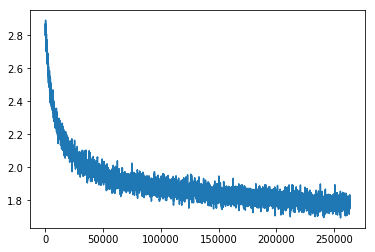

In [33]:
learner.sched.plot_loss()

# Classifier tokens

In [33]:
# tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')

In [34]:
# tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [8]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

# Classifier

In [9]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [10]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [11]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 110

In [12]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [13]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [14]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [15]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.7

In [16]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [17]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [18]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [19]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [20]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [21]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc_diag_top50_Svm_nov24_fastai0.7_80-20split')

In [50]:
learn.freeze_to(-1)

In [51]:
# learn.lr_find(lrs/1000)

In [52]:
# learn.sched.plot()

In [53]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                         
    0      2.226277   2.160699   0.343855  



[array([2.1607]), 0.3438552365663362]

In [54]:
learn.save('clas_0_Diagnosis_top50_Svm_nov24_fastai0.7_80-20split_lm_3epochs')

In [55]:
# learn.load('clas_0_Diagnosis_top50_Svm_nov24_fastai0.7_80-20split_lm_3epochs')

In [56]:
learn.freeze_to(-2)

In [57]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                           
    0      1.813502   1.483092   0.538088  



[array([1.48309]), 0.5380875864284205]

In [58]:
learn.save('clas_1_Diagnosis_top50_Svm_nov24_fastai0.7_80-20split_lm_3epochs')

In [22]:
learn.load('clas_1_Diagnosis_top50_Svm_nov24_fastai0.7_80-20split_lm_3epochs')

In [23]:
learn.unfreeze()

In [24]:
learn.fit(lrs, 1, wds=wd, cycle_len=9, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                           
    0      1.736419   1.39534    0.559423  
    1      1.65906    1.235866   0.607564                           
    2      1.632024   1.147281   0.638551                           
    3      1.599822   1.099634   0.65562                            
    4      1.49289    1.013516   0.682817                           
    5      1.535762   0.987967   0.691891                           
    6      1.471532   0.960328   0.699066                           
    7      1.37745    0.936635   0.705246                           
    8      1.422405   0.927792   0.707697                           



[array([0.92779]), 0.7076974674375122]

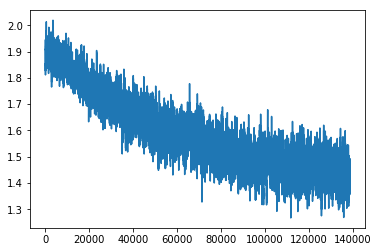

In [25]:
learn.sched.plot_loss()

In [27]:
learn.save('clas_2_Diagnosis_top50_Svm_nov24_fastai0.7_80-20split_lm_3epochs_classifier_9epochs')

In [ ]:
# !tar chvfz notebook.tar.gz *

# Fin

### Probabilities

In [28]:
log_preds = learn.predict()

In [29]:
log_preds[0]

array([ -4.17687,  -4.57815,  -4.8903 ,  -4.65579,  -1.70853,  -7.23557,  -8.37817,  -8.43329,  -9.84822,
       -10.19473,  -5.01014,  -4.04694,  -4.55527,  -4.00968,  -1.54332,  -9.49338,  -7.78211,  -7.11176,
        -7.13682,  -6.33894,  -8.74701,  -8.83403,  -7.88781,  -8.33108,  -7.42107,  -8.61473,  -8.2034 ,
        -8.76395,  -8.34251,  -8.95833,  -9.18147, -10.62185,  -9.34641,  -8.92547, -11.39208,  -7.72286,
        -6.02611, -10.29362,  -5.54879,  -4.45889,  -6.68967,  -9.39782,  -7.84556,  -7.66026,  -6.06084,
        -7.79519,  -5.94504, -11.43202,  -8.58219,  -5.94191,  -7.35041,  -4.30992, -15.41144, -14.67426,
       -15.50068, -16.6138 ], dtype=float32)

In [30]:
#Reference: https://forums.fast.ai/t/how-to-convert-multi-label-predictions-into-multi-class-probabilities/9450
#convert log_preds between 0 and 1
def sigmoid(z):
    return  1 / (1 + np.exp(-z))

In [31]:
log_preds_sigmoid = sigmoid(log_preds)

/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


In [32]:
log_preds_sigmoid[5]

array([0.00114, 0.00044, 0.00049, 0.00031, 0.03412, 0.00001, 0.     , 0.00001, 0.     , 0.     , 0.00024,
       0.00029, 0.00022, 0.0002 , 0.04646, 0.00001, 0.00002, 0.0002 , 0.00006, 0.00007, 0.     , 0.00001,
       0.00006, 0.00001, 0.00001, 0.00004, 0.0001 , 0.00004, 0.00001, 0.00002, 0.00002, 0.     , 0.00004,
       0.00007, 0.     , 0.00003, 0.00026, 0.     , 0.00176, 0.00059, 0.00011, 0.00004, 0.00001, 0.00004,
       0.0001 , 0.00021, 0.00073, 0.     , 0.00002, 0.00015, 0.00004, 0.00091, 0.     , 0.     , 0.     ,
       0.     ], dtype=float32)

### Predictions

In [33]:
y = log_preds
y

array([[ -4.17687,  -4.57815,  -4.8903 , ..., -14.67426, -15.50068, -16.6138 ],
       [ -9.68563,  -8.67288,  -9.13147, ..., -13.58052, -13.35534, -15.46919],
       [ -8.42537,  -7.0366 ,  -6.0225 , ..., -12.05225, -12.52318, -14.3348 ],
       ...,
       [  0.81288,   0.98034,   0.99079, ...,   1.91372,   1.28955,   0.05772],
       [  0.81288,   0.98034,   0.99079, ...,   1.91372,   1.28955,   0.05772],
       [  0.27907,   0.47106,   0.44741, ...,   0.65283,   0.02033,  -1.15017]], dtype=float32)

In [34]:
len(y)

211798

In [35]:
y.shape

(211798, 56)

In [36]:
predicted_values = np.argmax(y, axis=1)
predicted_values

array([14, 32, 46, ..., 18, 18, 18])

In [37]:
np.unique(predicted_values)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55])

In [38]:
len(predicted_values)

211798

In [39]:
predicted_values.shape

(211798,)

### Actual values

In [40]:
x,z = next(iter(md.val_dl))

In [41]:
a = []
for x,z in iter(md.val_dl):
    a.append(z)
print(a)

[
  4
 32
 46
 39
 26
  4
 14
  0
 10
 48
 14
 38
  7
 44
  4
 36
 20
 17
 38
 27
 23
 14
 42
 17
 32
  4
 40
 44
 28
 39
 14
 29
 35
 48
 28
 49
 25
 44
 29
 28
 17
 17
 32
 26
 32
 40
 36
 38
 47
 30
 17
 26
 44
 17
  2
 26
 14
 36
  4
 20
  1
 26
 14
 46
  2
 14
 44
 18
 16
 26
  5
 32
  4
 18
  5
 23
 36
 32
  4
  4
 36
 17
 36
  3
 39
 46
 49
 48
 13
 14
 36
 49
 19
 26
 32
 40
 27
  6
 14
 17
 16
 33
 38
 29
 17
 10
 28
  7
  0
  7
[torch.cuda.LongTensor of size 110 (GPU 1)]
, 
 16
  8
 24
 14
 17
 19
 36
  7
 27
 26
 27
 39
 17
  4
  4
  2
  0
 17
 15
 51
 36
 10
 14
 17
 15
 39
 46
  4
 36
 32
 17
 17
 14
 22
 44
 39
 46
 26
 29
 17
 32
 39
  4
 29
 50
  0
 14
 17
 14
  4
 17
 41
 32
 14
 44
 40
 32
 22
 40
  7
 39
 24
  4
 20
 36
 30
 26
 29
 29
 46
 29
 17
 32
 40
 51
 36
 36
  4
  0
 32
 33
 46
 19
 32
  3
 17
 16
 18
 30
 28
  4
 39
 51
 30
 46
  4
 26
  1
 32
 17
 44
 51
 23
 19
  1
 26
 32
 36
 14
  5
[torch.cuda.LongTensor of size 110 (GPU 1)]
, 
 29
 30
 26
  7
  4
 46


In [42]:
len(a)

1926

In [43]:
type(a)

list

In [44]:
actual_values = [item for sublist in a for item in sublist]
len(actual_values)

211798

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

labels = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55]
cm = confusion_matrix(predicted_values, actual_values, labels)
print(cm)

[[  346    20     1 ...     0     0     0]
 [   29   659     1 ...     2     3     1]
 [    4     5   501 ...     0     0     0]
 ...
 [    2    49     1 ... 23764  9161  2391]
 [    0    12     0 ...  3728 11012  1780]
 [    0     0     0 ...   432   462  1723]]


In [51]:
!pip install pandas_ml --user

In [57]:
!pip show pandas_ml

Name: pandas-ml
Version: 0.5.0
Summary: pandas, scikit-learn and xgboost integration
Home-page: http://pandas-ml.readthedocs.org/en/stable
Author: sinhrks
Author-email: sinhrks@gmail.com
License: BSD
Location: /home/nuthakkisiddhartha/.local/lib/python3.6/site-packages
Requires: enum34, pandas
Required-by: 


In [58]:
import sys
sys.path.append('/home/nuthakkisiddhartha/.conda/envs/fastai/lib/python3.6/site-packages')
sys.path.append('/home/nuthakkisiddhartha/.local/lib/python3.6/site-packages')

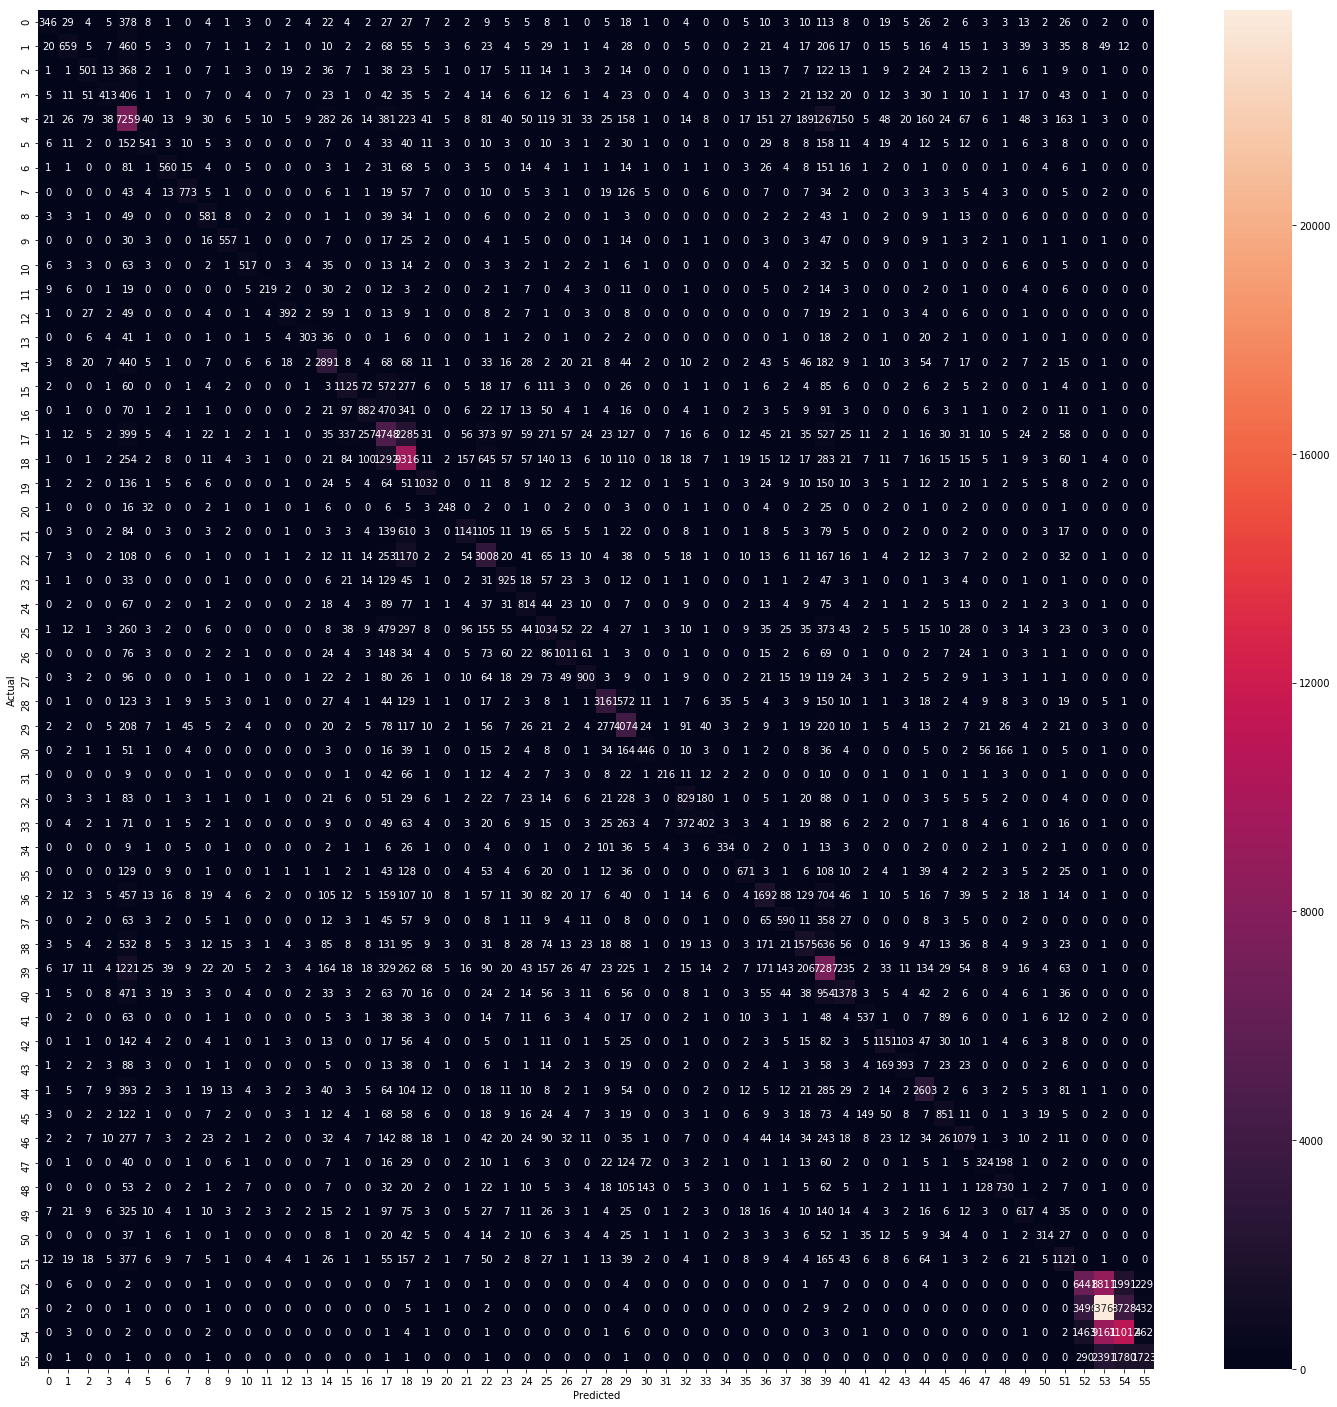

In [60]:
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt

cm = ConfusionMatrix(actual_values, predicted_values)
cm
conf_mat = confusion_matrix(actual_values, predicted_values)
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
from sklearn.metrics import classification_report
print(classification_report(actual_values, predicted_values))

              precision    recall  f1-score   support

           0       0.73      0.29      0.42      1190
           1       0.72      0.35      0.47      1894
           2       0.64      0.38      0.47      1331
           3       0.73      0.29      0.42      1404
           4       0.43      0.63      0.51     11440
           5       0.71      0.46      0.56      1180
           6       0.75      0.53      0.62      1048
           7       0.84      0.65      0.73      1183
           8       0.65      0.71      0.68       816
           9       0.83      0.73      0.77       766
          10       0.87      0.69      0.77       751
          11       0.80      0.58      0.67       376
          12       0.82      0.62      0.70       637
          13       0.86      0.65      0.74       465
          14       0.67      0.69      0.68      4166
          15       0.60      0.46      0.52      2441
          16       0.61      0.41      0.49      2165
          17       0.44    

In [62]:
def accuracy(predicted_labels, actual_labels):
    diff = predicted_labels - actual_labels
    return 1.0 - (float(np.count_nonzero(diff)) / len(diff))

In [63]:
accuracy(predicted_values, actual_values)

0.5571865645567946

In [64]:
accuracy_np(*learn.predict_with_targs())

0.5571865645567947

### AUROC testing and output result

In [65]:
actual_values_df = pd.DataFrame(np.array(actual_values), index=None)
print (len(actual_values_df))
print(actual_values_df.head())

211798
    0
0   4
1  32
2  46
3  39
4  26


In [67]:
predicted_values_df = pd.DataFrame(np.array(predicted_values), index = None)
print (len(predicted_values_df))
print(predicted_values_df.head())

211798
    0
0  14
1  32
2  46
3  39
4  26


In [68]:
#For multiclass ROC curve dividing data into test and train
#Plotted between 'actual values' and 'predicted values'
from sklearn.model_selection import train_test_split
X = actual_values_df[0].values
y = predicted_values_df[0].values

# Add noisy features to make the problem harder
random_state = 0

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2
                                                    ,random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(169438,)
(42360,)
(169438,)
(42360,)


In [ ]:
#METHOD 2
#Multiclass ROC curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
X = actual_values_df[0].values
y = predicted_values_df[0].values

labels = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55]
# Binarize the output
y = label_binarize(y, classes=labels)
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = 0

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))

y_score = classifier.fit(X_train.reshape(169438,1), y_train).decision_function(X_test.reshape(42360,1))


#Compute ROC curve and ROC area for each class
lw = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="best")

#Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
!tar chvfz /home/snuthakk/Capstone/mimic_diag_seq1_top10_90:10split/models.tar.gz /home/snuthakk/Capstone/mimic_diag_seq1_top10_90:10split/models/*

In [ ]:
!tar chvfz /home/snuthakk/Capstone/mimic_diag_seq1_top10_clas_90_10split.tar.gz /home/snuthakk/Capstone/mimic_diag_seq1_top10_clas_90:10split/*